### PCA for visualization: Hand-written digits

• The usefulness of the dimensionality reduction may not be entirely apparent in only two dimensions, but becomes much more clear when looking at high-dimensional data.

• To see this, let's take a quick look at the application of PCA to the digits data we saw in In-Depth: Decision Trees and Random Forests.

• We start by loading the data:

In [4]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

• Recall that the data consists of 8×8 pixel images, meaning that they are 64-dimensional.

• To gain some intuition into the relationships between these points, we can use PCA to project them to a more manageable number of dimensions, say two:

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # Projects from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


• We can now plot the first two principal components of each point to learn about the data:

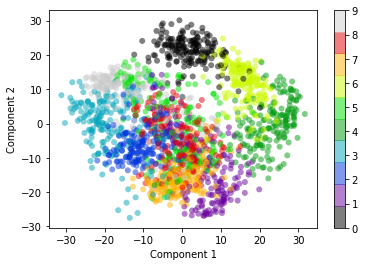

In [6]:
import matplotlib.pyplot as plt
plt.scatter(projected[:, 0], projected[:, 1], c=digits.target, edgecolors='none',
           alpha=0.5, cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar();

• Recall what these components mean: the full data is a 64-dimensional point cloud, and these points are the projection of each data point along the directions with the largest variance.

• Essentially, we have found the optimal stretch and rotation in 64-dimensional space that allows us to see the layout of the digits in two dimensions, and have done this in an unsupervised manner—that is, without reference to the labels.

### What do the components mean?

• We can go a bit further here, and begin to ask what the reduced dimensions mean.

• This meaning can be understood in terms of combinations of basis vectors.

• For example, each image in the training set is defined by a collection of 64 pixel values, which we will call the vector $x$:

                                x=[x1,x2,x3⋯x64]
                                
• One way we can think about this is in terms of a pixel basis.

• That is, to construct the image, we multiply each element of the vector by the pixel it describes, and then add the results together to build the image:

                     image(x)=x1⋅(pixel 1)+x2⋅(pixel 2)+x3⋅(pixel 3)⋯x64⋅(pixel 64)
                     
• One way we might imagine reducing the dimension of this data is to zero out all but a few of these basis vectors.

• The upper row of panels shows the individual pixels, and the lower row shows the cumulative contribution of these pixels to the construction of the image.

• Using only eight of the pixel-basis components, we can only construct a small portion of the 64-pixel image. 

• Were we to continue this sequence and use all 64 pixels, we would recover the original image.

• But the pixel-wise representation is not the only choice of basis.

• We can also use other basis functions, which each contain some pre-defined contribution from each pixel, and write something like

                    image(x)=mean+x1⋅(basis 1)+x2⋅(basis 2)+x3⋅(basis 3)⋯
                    
• PCA can be thought of as a process of choosing optimal basis functions, such that adding together just the first few of them is enough to suitably reconstruct the bulk of the elements in the dataset.

• The principal components, which act as the low-dimensional representation of our data, are simply the coefficients that multiply each of the elements in this series.

• This figure shows a similar depiction of reconstructing this digit using the mean plus the first eight PCA basis functions:

• Unlike the pixel basis, the PCA basis allows us to recover the salient features of the input image with just a mean plus eight components! The amount of each pixel in each component is the corollary of the orientation of the vector in our two-dimensional example.

• This is the sense in which PCA provides a low-dimensional representation of the data: it discovers a set of basis functions that are more efficient than the native pixel-basis of the input data.

### Choosing the number of components

• A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data.

• This can be determined by looking at the cumulative explained variance ratio as a function of the number of components:

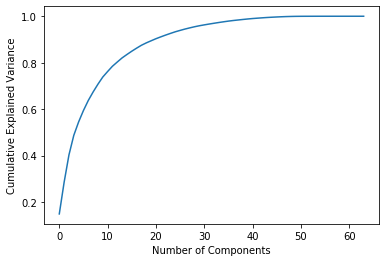

In [9]:
import numpy as np
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');